## Dimension Reduction Methods

### [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)

- Principal Component Analysis (PCA) is a classical method for dimension reduction and data visualization.
- The goal is to obtain lower-dimensional data while preserving as much of the data's variance as possible.
- If only 2 principal compenents are used, then the data points can be visualized in a scatter plot.

#### Theory

- input matrix: $X \in \mathbb{R}^{n \times d}$
- eigenvalue decomposition of the "covariance" matrix: $X^T X = W \Lambda W^T$,<br>where $\Lambda$ is the diagonal matrix of eigenvalues and the columns of $W$ contain the associated eigenvectors
- the eigenvalues are sorted in descending order
- dimensionality reduction: $Y = X W_K$, where $K < d$ and $W_K$ contains the first $K$ columns of $W$

**Exercise 1**: Visualize the Wisconsin Breast Cancer data set using PCA!

In [1]:
# Load the data to DataFrame.
import pandas as pd
names = [
    'Sample_code_number', 'Clump_Thickness', 'Uniformity_of_Cell_Size',
    'Uniformity_of_Cell_Shape', 'Marginal_Adhesion', 'Single_Epithelial_Cell_Size',
    'Bare_Nuclei', 'Bland_Chromatin', 'Normal_Nucleoli', 'Mitoses', 'Class'
]
df = pd.read_csv('../_data/wisconsin_data.txt', sep=',', names=names, na_values='?')
df['Bare_Nuclei'].fillna(0, inplace=True)
df.head()

,Sample_code_number,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2


In [2]:
X = df[df.columns[1:-1]].values   # input matrix
y = (df['Class'] // 2 - 1).values # target voctor
X.shape

(699, 9)

In [3]:
# NumPy based implementation.
import numpy as np
X2 = X - X.mean(axis=0)         # subtract column means
L, W = np.linalg.eig(X2.T @ X2)
W2 = W[:, L.argsort()[::-1]]    # sort W according to L
Z = X2 @ W2[:, :2]              # reduce dimensions to 2
print(Z.shape)
Z

(699, 2)


array([[  4.40904732,  -0.01994907],
       [ -4.88110465,   4.90332617],
       [  4.56415067,   0.65506726],
       ...,
       [-10.33687644,  -7.24412961],
       [ -6.47179821,  -2.54870704],
       [ -7.56560301,  -1.23300626]])

In [4]:
# Scikit-Learn based implementation.
from sklearn.decomposition import PCA
pca = PCA(2).fit(X) # compute top 2 eigenvectors
pca.transform(X)    # reduce dimension

array([[-4.40904732,  0.01994907],
       [ 4.88110465, -4.90332617],
       [-4.56415067, -0.65506726],
       ...,
       [10.33687644,  7.24412961],
       [ 6.47179821,  2.54870704],
       [ 7.56560301,  1.23300626]])

In [5]:
# ...alternatively, we can use fit_transform()
Z = PCA(2).fit_transform(X)
Z

array([[-4.40904732,  0.01994907],
       [ 4.88110465, -4.90332617],
       [-4.56415067, -0.65506726],
       ...,
       [10.33687644,  7.24412961],
       [ 6.47179821,  2.54870704],
       [ 7.56560301,  1.23300626]])

In [6]:
# The same with the truncated SVD algorithm.
from sklearn.decomposition import TruncatedSVD
TruncatedSVD(2).fit_transform(X2)

array([[-4.40904732,  0.01994907],
       [ 4.88110465, -4.90332617],
       [-4.56415067, -0.65506726],
       ...,
       [10.33687644,  7.24412961],
       [ 6.47179821,  2.54870704],
       [ 7.56560301,  1.23300626]])

[]

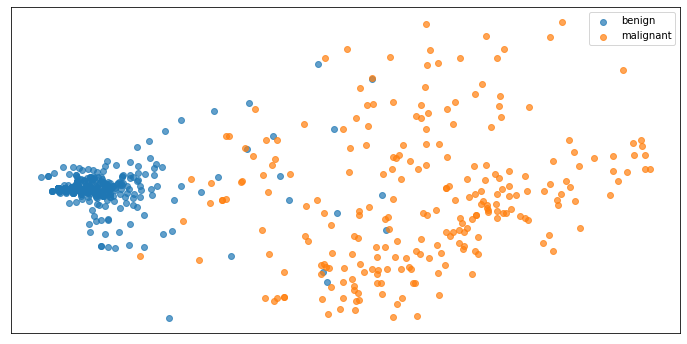

In [7]:
# Visualization.
import matplotlib.pyplot as plt
cond = (y == 0) # is the example benign?
plt.figure(figsize=(12, 6))
plt.scatter(Z[cond, 0], Z[cond, 1], alpha=0.7)
plt.scatter(Z[~cond, 0], Z[~cond, 1], alpha=0.7)
plt.legend(['benign', 'malignant'])
plt.gca().set_xticks([])
plt.gca().set_yticks([])

**Exercise 2**: On the SMS spam data set, measure the cross-validation accuracy of gradient boosting, so that we reduce the dimension of the input to 100, 200, and 300 using PCA.

In [8]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv('../_data/smsspam.txt', sep='\t', names=['label', 'text'])
X = CountVectorizer(binary=True).fit_transform(df['text']) # input matrix
y = (df['label'] == 'spam').astype('int').values           # target vector

In [9]:
X.shape

(5572, 8713)

In [10]:
y

array([0, 0, 1, ..., 0, 0, 0])

In [12]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
from lightgbm import LGBMClassifier

cv = ShuffleSplit(1, random_state=42, test_size=0.3)
for K in [20, 50, 100, 200, 300]:
    X2 = TruncatedSVD(K, random_state=42).fit_transform(X)
    cl = LGBMClassifier(random_state=42)
    score = cross_val_score(cl, X2, y, cv=cv, scoring='accuracy').mean()
    print(K, score)

20 0.9748803827751196
50 0.9784688995215312
100 0.979066985645933
200 0.9802631578947368
300 0.9796650717703349


In [14]:
from sklearn.linear_model import LogisticRegression

cl = LogisticRegression()
cross_val_score(cl, X2, y, cv=cv, scoring='accuracy').mean()

0.9868421052631579

In [15]:
cross_val_score(cl, X, y, cv=cv, scoring='accuracy').mean()

0.9868421052631579

### [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)

- t-Distributed Stochastic Neighbor Embedding (t-SNE) can be viewed as a modernized version of PCA.
- PCA is global in nature: it tries to preserve the distances between any pairs of data points. This leads to visualizations where the points form an elliptical blob.
- The key idea of t-SNE is to is to preserve only the local relationship between the data points. If two data points are close in the original space, then they should be close in the transformed space too. However, large distances in the original space are not preserved in the transformed space.
- A detailed blog post about t-SNE and PCA can be read [here](https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a).


#### Theory

- data points (rows of the input matrix): $x_1, \dots, x_n \in \mathbb{R}^d$
- conditional probabilities: $p_{j|i} = \frac{\exp(-\|x_i - x_j\|^2 / (2\sigma^2))}{\sum_{k \neq i} \exp(-\|x_i - x_k\|^2 / (2\sigma^2))}$, $p_{i|i} = 0$
- probabilities: $p_{ij} = \frac{p_{j|i} + p_{i|j}}{2n}$
- the $\sigma_i$ values are is set using the bisection method so that the [perplexity](https://en.wikipedia.org/wiki/Perplexity) of the conditional distribution equals a predefined perplexity
- transformed data points: $y_1, \dots, y_n \in \mathbb{R}^K$
- transformed probabilities: $q_{ij} = \frac{\left(1 + \|y_i - y_j\|^2\right)^{-1}}{\sum_k \sum_{l \neq k} \left(1 + \|y_k - y_l\|^2\right)^{-1}}$
-  Kullback–Leibler divergence: $KL(y_1, \dots, y_n) = \sum_{i \neq j} p_{ij} \log \frac{p_{ij}}{q_{ij}}$
- the minimization of the KL divergence performed using approximate gradient descent

**Exercise 3**: Prepare the t-SNE visualization of the Wisconsin Breast Cancer data set.

**Exercise 4**: Prepare the t-SNE visualization of the Titanic data set.